# ChatGPT output

In [57]:
import pandas as pd
import numpy as np
from datetime import datetime

# Function to simulate monthly income
def simulate_income(start_date, end_date, base_income, variance, trend_dates):
    dates = pd.date_range(start_date, end_date, freq='MS')
    incomes = []
    
    for date in dates:
        if date < trend_dates['start']:
            income = np.random.normal(base_income, variance)
        elif trend_dates['start'] <= date < trend_dates['recovery_start']:
            # Decrease income during the pandemic start phase
            income = np.random.normal(base_income * 0.5, variance)
        elif trend_dates['recovery_start'] <= date <= trend_dates['end']:
            # Gradually increase income during recovery
            recovery_period = (trend_dates['end'] - trend_dates['recovery_start']).days
            current_recovery_time = (date - trend_dates['recovery_start']).days
            recovery_factor = 0.5 + 0.5 * (current_recovery_time / recovery_period)
            income = np.random.normal(base_income * recovery_factor, variance)
        else:
            income = np.random.normal(base_income, variance)
        incomes.append(income)
    
    return pd.DataFrame({'date': dates, 'average_monthly_income': incomes})

# Parameters
start_date = '2018-01-01'
end_date = '2023-05-30'
retail_groups = ["Fashion", "Electronics", "Groceries", "Restaurants"]
base_income = 10  # Millions of dollars
variance = 0.5  # Small variance
trend_dates = {
    'start': datetime(2020, 3, 1),
    'recovery_start': datetime(2021, 7, 1),
    'end': datetime(2023, 5, 30)
}

# Generate dataset
all_data = []
for group in retail_groups:
    group_data = simulate_income(start_date, end_date, base_income, variance, trend_dates)
    group_data['retail_group'] = group
    all_data.append(group_data)

df = pd.concat(all_data)
df.to_csv('retail_data.csv', index=False)
print("Dataset 'retail_data.csv' has been created with {} rows.".format(len(df)))

Dataset 'retail_data.csv' has been created with 260 rows.


# Imports and data transformations

In [58]:
df = pd.read_csv('retail_data.csv')

In [59]:
import imageio
import numpy as np
import pandas as pd

from io import BytesIO
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "jupyterlab"

# df = pd.read_csv('retail_data.csv')
df['date'] = pd.to_datetime(df['date']
                            .astype(str)
                            .str[:7],
                            format="%Y-%m") # Control ChatGPT date format output
df = df.sort_values(['date', 'retail_group'], ignore_index=True)
 
RETAIL_GROUP_COLORS = ['#1F4068', '#527a82', '#DE8918', '#BF3200']
N_UNIQUE_RETAIL_GROUPS = df['retail_group'].nunique()

In [60]:
df_indexed = pd.DataFrame()
for index in np.arange(start=0,
                       stop=len(df)+1,
                       step=N_UNIQUE_RETAIL_GROUPS):
    df_slicing = df.iloc[:index].copy()
    df_slicing['frame'] = (index//N_UNIQUE_RETAIL_GROUPS)
    df_indexed = pd.concat([df_indexed, df_slicing])

# Scatter plot

In [61]:
scatter_plot = px.scatter(
    df_indexed,
    x='date',
    y='average_monthly_income',
    color='retail_group',
    animation_frame='frame',
    color_discrete_sequence=RETAIL_GROUP_COLORS
)
 
for frame in scatter_plot.frames:
    for data in frame.data:
        data.update(mode='markers',
                    showlegend=True,
                    opacity=1)
        data['x'] = np.take(data['x'], [-1])
        data['y'] = np.take(data['y'], [-1])

# Line plot

In [62]:
line_plot = px.line(
    df_indexed,
    x='date',
    y='average_monthly_income',
    color='retail_group',
    animation_frame='frame',
    color_discrete_sequence=RETAIL_GROUP_COLORS,
    width=1000,
    height=500,
    line_shape='spline' # make a line graph curvy
)
line_plot.update_traces(showlegend=False)  # legend will be from line graph
for frame in line_plot.frames:
    for data in frame.data:
        data.update(mode='lines', opacity=0.8, showlegend=False)

# Stationary combined plot

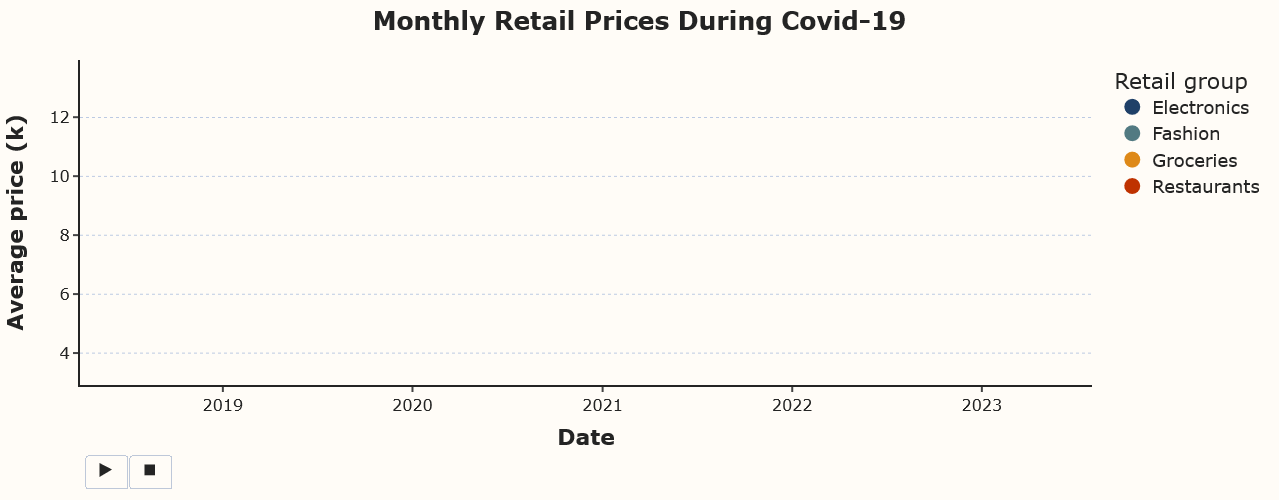

In [63]:
combined_plot = go.Figure(
    data=line_plot.data + scatter_plot.data,
    frames=[
        go.Frame(data=line_plot.data + scatter_plot.data, name=scatter_plot.name)
        for line_plot, scatter_plot in zip(line_plot.frames, scatter_plot.frames)
        # frame.update(
        #     layout={
        #         'xaxis': {'tickformat': '%Y',
        #                   'tickangle': 0,
        #                   'tickvals': df[df['date'].dt.month==1]['date'].unique()}}),
 ],
    layout=line_plot.layout
)

combined_plot.update_yaxes(
    gridcolor='#7a98cf',
    griddash='dot',
    gridwidth=.5,
    linewidth=2,
    tickwidth=2
)

combined_plot.update_xaxes(
    title_font=dict(size=16),
    linewidth=2,
    tickwidth=2
)
 
combined_plot.update_traces(
    line=dict(width=5),
    marker=dict(size=25))
 
combined_plot.update_layout(
    font=dict(size=18),
    yaxis=dict(tickfont=dict(size=16)),
    xaxis=dict(tickfont=dict(size=16)),
    showlegend=True,
    legend=dict(
        title='Retail group'),
    template='simple_white',
    title="<b>Monthly Retail Prices During Covid-19</b>",
    yaxis_title="<b>Average price (k)</b>",
    xaxis_title="<b>Date</b>",
    yaxis_showgrid=True,
    xaxis_range=[df_indexed['date'].min() + pd.DateOffset(months=3),
                 df_indexed['date'].max() + pd.DateOffset(months=3)],
    yaxis_range=[df_indexed['average_monthly_income'].min()*0.75,
                 df_indexed['average_monthly_income'].max()*1.25],
    plot_bgcolor='#fffcf7',
    paper_bgcolor='#fffcf7',
    title_x=0.5
)
 
# adjust speed of animation
combined_plot['layout'].pop("sliders")
combined_plot.layout.updatemenus[0].buttons[0]['args'][1]['frame']['duration'] = 120
combined_plot.layout.updatemenus[0].buttons[0]['args'][1]['transition']['duration'] = 50
combined_plot.layout.updatemenus[0].buttons[0]['args'][1]['transition']['redraw'] = False
combined_plot.show()
 

# Autoscaled combined plot

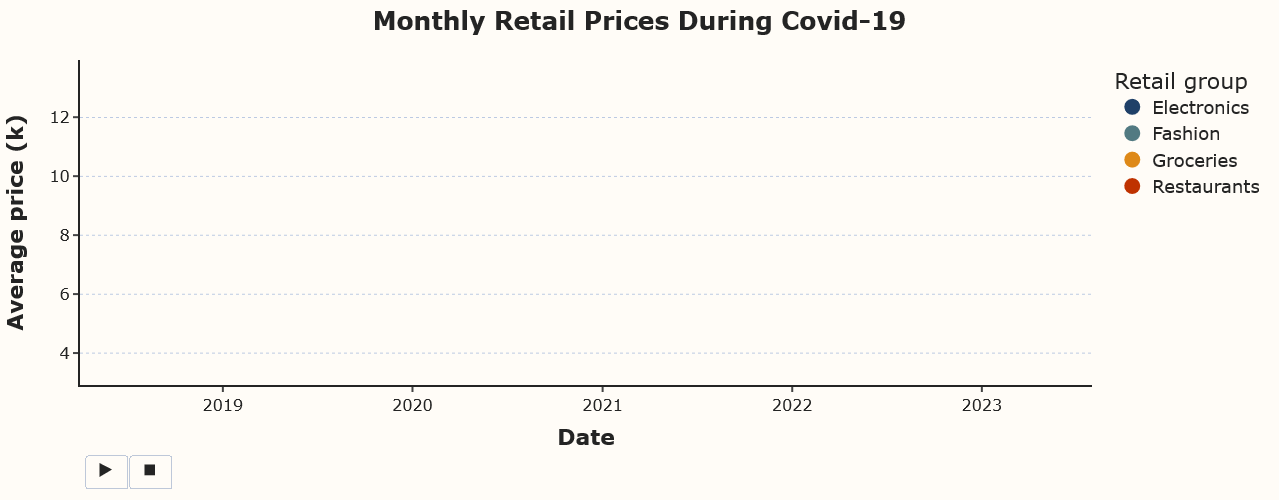

In [64]:
combined_plot = go.Figure(
    data=line_plot.data + scatter_plot.data,
    frames=[
        frame.update(
            layout={
                'xaxis': {'range': [min(frame.data[0].x),
                                    max(frame.data[0].x + pd.DateOffset(months=2))],
                          'tickformat': '%Y',
                          'tickangle': 0,
                          'tickvals': df[df['date'].dt.month==1]['date'].unique()},
                'yaxis': {'range': [min(frame.data[0].y)*0.2,
                                    max(frame.data[0].y)*1.5],
                          'nticks': 6},
            }
        )
        for frame in combined_plot.frames
    ],
    layout=line_plot.layout
)
 
combined_plot.update_yaxes(
    gridcolor='#7a98cf',
    griddash='dot',
    gridwidth=.5,
    linewidth=2,
    tickwidth=2
)
 
combined_plot.update_xaxes(
    title_font=dict(size=16),
    linewidth=2,
    tickwidth=2
)
 
combined_plot.update_traces(
    line=dict(width=5),
    marker=dict(size=25))
 
combined_plot.update_layout(
    font=dict(size=18),
    yaxis=dict(tickfont=dict(size=16)),
    xaxis=dict(tickfont=dict(size=16)),
    showlegend=True,
    legend=dict(
        title='Retail group'),
    template='simple_white',
    title="<b>Monthly Retail Prices During Covid-19</b>",
    yaxis_title="<b>Average price (k)</b>",
    xaxis_title="<b>Date",
    yaxis_showgrid=True,
    xaxis_range=[df_indexed['date'].min() + pd.DateOffset(months=3),
                 df_indexed['date'].max() + pd.DateOffset(months=3)],
    yaxis_range=[df_indexed['average_monthly_income'].min()*0.75,
                 df_indexed['average_monthly_income'].max()*1.25],
    plot_bgcolor='#fffcf7',
    paper_bgcolor='#fffcf7',
    title_x=0.5
)

# adjust speed of animation
combined_plot['layout'].pop("sliders")
combined_plot.layout.updatemenus[0].buttons[0]['args'][1]['frame']['duration'] = 150
combined_plot.layout.updatemenus[0].buttons[0]['args'][1]['transition']['duration'] = 120
combined_plot.layout.updatemenus[0].buttons[0]['args'][1]['transition']['redraw'] = False
combined_plot.show()

# Save as GIF

## Stationary plot

In [ ]:
# Initialize an empty list to hold the in-memory images
in_memory_images = []

for frame in combined_plot.frames:
    # Create a new figure for each frame to avoid mutation issues
    frame_fig = go.Figure()

    # Apply layout from your combined plot
    frame_fig.update_layout(combined_plot.layout)

    # Remove sliders and updatemenus for the frame's figure
    frame_fig.layout.pop("sliders", None)
    frame_fig.layout.pop('updatemenus', None)

    # Add traces from the current frame to the figure
    for trace in frame.data:
        frame_fig.add_trace(trace)

    # Update trace styles if needed
    frame_fig.update_traces(
        line=dict(width=5),
        marker=dict(size=25))

    # Convert the figure to a PNG image in memory
    img_bytes = pio.to_image(frame_fig, format='png', width=1000, height=500)
    in_memory_images.append(img_bytes)

# Now, read these in-memory images with imageio and create a GIF
images_for_gif = [imageio.imread(BytesIO(img_bytes)) for img_bytes in in_memory_images]

# Save the images as a GIF
imageio.mimsave('staionary_animation.gif', images_for_gif, fps=300, palettesize=256)  # Adjust FPS as necessary

## Autoscaled plot

In [ ]:
import plotly.graph_objects as go
import imageio
from io import BytesIO
import plotly.io
import pandas as pd

# Initialize an empty list to hold the in-memory images
in_memory_images = []

for frame in combined_plot.frames:
    # Create a new figure for each frame
    frame_fig = go.Figure()

    # Copy the layout from line_plot or scatter_plot, they should be similar
    frame_fig.update_layout(line_plot.layout)

    # Add traces from the current frame to the figure
    for trace in frame.data:
        frame_fig.add_trace(trace)

    # Calculate dynamic x and y axis ranges
    x_values = pd.to_datetime(frame.data[0].x)  # Convert x values to datetime if they aren't already
    y_values = frame.data[0].y
    
    # Update layout for dynamic axis ranges
    frame_fig.update_layout(
        xaxis_range=[x_values.min(), x_values.max() + pd.DateOffset(months=2)],
        yaxis_range=[min(y_values) * 0.2, max(y_values) * 1.5],
        xaxis_tickformat='%Y',
        xaxis_tickangle=0,
        xaxis_nticks=5,
        yaxis_nticks=6,
        font=dict(size=18),
        showlegend=True,
        legend=dict(
            title='Retail group'),
        template='simple_white',
        title="<b>Monthly Retail Prices During Covid-19</b>",
        yaxis_title="<b>Average price (k)</b>",
        xaxis_title="<b>Date</b>",
        yaxis_showgrid=True,
        plot_bgcolor='#fffcf7',
        paper_bgcolor='#fffcf7',
        title_x=0.5,
        yaxis=dict(
            tickfont=dict(size=16),
            gridcolor='#7a98cf',
            griddash='dot',
            gridwidth=.5,
            linewidth=2,
            tickwidth=2
        ),
        xaxis=dict(
            tickfont=dict(size=16),
            title_font=dict(size=16),
            linewidth=2,
            tickwidth=2,
            tickvals=df[df['date'].dt.month==1]['date'].unique()
        )
    )
    # Update trace styles if needed
    frame_fig.update_traces(
        line=dict(width=5),
        marker=dict(size=25))

    # Remove sliders and updatemenus for the frame's figure
    frame_fig.layout.pop("sliders", None)
    frame_fig.layout.pop('updatemenus', None)

    # Convert the figure to a PNG image in memory
    img_bytes = pio.to_image(frame_fig, format='png', width=1000, height=500)
    in_memory_images.append(img_bytes)

# Now, read these in-memory images with imageio and create a GIF
images_for_gif = [imageio.imread(BytesIO(img_bytes)) for img_bytes in in_memory_images]

# Save the images as a GIF
imageio.mimsave('autoscaled_animation.gif', images_for_gif, duration=100, palettesize=256)